In [14]:
# worldcup_winner_model_fixed_eval.py
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import LeaveOneGroupOut
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)

# -------------------------
# 1) Load data
# -------------------------
players = pd.read_csv('/workspaces/FIFA-World-Cup-goal-prediction/data/WorldCupPlayers.csv')
cups = pd.read_csv('/workspaces/FIFA-World-Cup-goal-prediction/data/WorldCups.csv')
matches = pd.read_csv('/workspaces/FIFA-World-Cup-goal-prediction/data/WorldCupMatches.csv')

# -------------------------
# 2) Build participants by year (same as you)
# -------------------------
teams_by_year = {}
for year, g in matches.groupby('Year'):
    home = g['Home Team Name'].unique().tolist()
    away = g['Away Team Name'].unique().tolist()
    teams = sorted(set(home + away))
    teams_by_year[int(year)] = teams

rows = []
for year, teams in teams_by_year.items():
    for t in teams:
        rows.append({'Year': int(year), 'Country': t})
df_part = pd.DataFrame(rows)

# -------------------------
# 3) Map winners & hosts
# -------------------------
winner_by_year = cups.set_index('Year')['Winner'].to_dict()
host_by_year = cups.set_index('Year')['Country'].to_dict()

df_part['WinnerLabel'] = df_part.apply(lambda r: 1 if (r['Year'] in winner_by_year and winner_by_year[r['Year']] == r['Country']) else 0, axis=1)
df_part['IsHost'] = df_part.apply(lambda r: 1 if (r['Year'] in host_by_year and host_by_year[r['Year']] == r['Country']) else 0, axis=1)

# -------------------------
# 4) Precompute goals/matches by team/year (safe: used only for prior years)
# -------------------------
matches = matches.copy()
matches['Home Team Goals'] = pd.to_numeric(matches['Home Team Goals'], errors='coerce').fillna(0).astype(int)
matches['Away Team Goals'] = pd.to_numeric(matches['Away Team Goals'], errors='coerce').fillna(0).astype(int)

goals_stats_by_year = {}
for year, g in matches.groupby('Year'):
    d = defaultdict(lambda: {'goals':0,'matches':0})
    for _, row in g.iterrows():
        h = row['Home Team Name']; a = row['Away Team Name']
        hg = int(row['Home Team Goals']); ag = int(row['Away Team Goals'])
        d[h]['goals'] += hg; d[h]['matches'] += 1
        d[a]['goals'] += ag; d[a]['matches'] += 1
    goals_stats_by_year[int(year)] = {team: vals for team, vals in d.items()}

# -------------------------
# 5) Fixed cumulative feature construction (use prior years only)
# -------------------------
tournament_years = sorted(cups['Year'].unique())

cum_wins = defaultdict(int)
cum_runners = defaultdict(int)
cum_top4 = defaultdict(int)
cum_appearances = defaultdict(int)

feature_rows = []

for year in sorted(tournament_years):
    teams = teams_by_year.get(year, [])
    # build features using only prior years
    for country in teams:
        feats = {
            'Year': year,
            'Country': country,
            'prior_wins': cum_wins[country],
            'prior_runners_up': cum_runners[country],
            'prior_top4': cum_top4[country],
            'prior_appearances': cum_appearances[country],
            'is_host': 1 if host_by_year.get(year) == country else 0,
            'winner_label': 1 if winner_by_year.get(year) == country else 0
        }
        # avg goals per match in prior years (only)
        total_goals = 0
        total_matches = 0
        for y2, stats in goals_stats_by_year.items():
            if y2 < year and country in stats:
                total_goals += stats[country]['goals']
                total_matches += stats[country]['matches']
        feats['avg_goals_per_match_prior'] = (total_goals / total_matches) if total_matches > 0 else 0.0

        # last finish prior to year (0 = no participation; 1=winner;2=runner;3=third;4=fourth;5=other)
        last_finish = 0
        for yprev in sorted([y for y in tournament_years if y < year], reverse=True):
            if country in teams_by_year.get(yprev, []):
                w = winner_by_year.get(yprev, None)
                r = cups.loc[cups['Year']==yprev, 'Runners-Up'].item()
                t3 = cups.loc[cups['Year']==yprev, 'Third'].item()
                t4 = cups.loc[cups['Year']==yprev, 'Fourth'].item()
                if w == country:
                    last_finish = 1
                elif r == country:
                    last_finish = 2
                elif t3 == country:
                    last_finish = 3
                elif t4 == country:
                    last_finish = 4
                else:
                    last_finish = 5
                break
        feats['last_finish_code'] = last_finish

        feature_rows.append(feats)

    # AFTER constructing features for year, update cumulative stats using results of this year
    for team in teams:
        cum_appearances[team] += 1
    # safe .item() because cups has an entry for each year
    winner = cups.loc[cups['Year']==year, 'Winner'].item()
    runner = cups.loc[cups['Year']==year, 'Runners-Up'].item()
    third = cups.loc[cups['Year']==year, 'Third'].item()
    fourth = cups.loc[cups['Year']==year, 'Fourth'].item()

    cum_wins[winner] += 1
    cum_runners[runner] += 1
    cum_top4[winner] += 1
    cum_top4[runner] += 1
    cum_top4[third] += 1
    cum_top4[fourth] += 1

features_df = pd.DataFrame(feature_rows)
print("Constructed dataset shape:", features_df.shape)
print(features_df.head(8))

# -------------------------
# 6) Features / labels
# -------------------------
feature_cols = ['prior_wins','prior_runners_up','prior_top4','prior_appearances',
                'avg_goals_per_match_prior','last_finish_code','is_host']
X = features_df[feature_cols].copy()
y = features_df['winner_label'].copy()
years = features_df['Year'].copy()

# Models to evaluate
models = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(class_weight='balanced', max_iter=2000))]),
    'RandomForest': RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
    'SVM': Pipeline([('scaler', StandardScaler()), ('clf', SVC(class_weight='balanced', probability=True))]),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=300, random_state=42)
}

# -------------------------
# 7A) Time-based validation (train on all years < Y, test on Y)
# -------------------------
print("\n=== Time-based validation (train on years < Y, test on year Y) ===")
time_results = {name: {'row_acc': [], 'row_roc': [], 'top1_acc': []} for name in models}
unique_years = sorted(features_df['Year'].unique())

# skip the first year (no prior data) - start from second tournament
for idx, test_year in enumerate(unique_years):
    # ensure there is at least one prior year to train on
    train_years = [y for y in unique_years if y < test_year]
    if len(train_years) == 0:
        continue
    train_mask = features_df['Year'].isin(train_years)
    test_mask = features_df['Year'] == test_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    test_df = features_df[test_mask].copy()

    for name, model in models.items():
        model.fit(X_train, y_train)
        # get probabilities
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:,1]
        else:
            try:
                probs = model.decision_function(X_test)
                probs = (probs - probs.min()) / (probs.max() - probs.min() + 1e-9)
            except:
                probs = model.predict(X_test)
        y_pred = (probs >= 0.5).astype(int)
        time_results[name]['row_acc'].append(accuracy_score(y_test, y_pred))
        time_results[name]['row_roc'].append(roc_auc_score(y_test, probs) if len(set(y_test))>1 else np.nan)

        # tournament-level top-1: does the top predicted team equal actual winner?
        test_df = test_df.copy()
        test_df['pred_prob'] = probs
        top_pred = test_df.loc[test_df['pred_prob'].idxmax()]
        actual_winner = winner_by_year.get(test_year, None)
        top1 = 1 if (actual_winner is not None and top_pred['Country'] == actual_winner) else 0
        time_results[name]['top1_acc'].append(top1)

# summarize time-based results
for name, stats in time_results.items():
    row_acc = np.nanmean(stats['row_acc'])
    row_roc = np.nanmean([v for v in stats['row_roc'] if not np.isnan(v)]) if len(stats['row_roc'])>0 else np.nan
    top1 = np.nanmean(stats['top1_acc'])
    print(f"{name}: mean_row_acc={row_acc:.4f}, mean_row_roc={row_roc if not np.isnan(row_roc) else 'nan'}, mean_top1_acc={top1:.4f}")

# -------------------------
# 7B) Group CV (LeaveOneGroupOut by Year) - ensures no splitting within same year
# -------------------------
print("\n=== Leave-One-Year-Out CV (grouped by Year) ===")
logo = LeaveOneGroupOut()
group = years.values
group_results = {name: {'row_acc': [], 'row_roc': [], 'top1_acc': []} for name in models}

for name, model in models.items():
    for train_idx, test_idx in logo.split(X, y, groups=group):
        # skip folds where train has no positive class (unlikely but safe)
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:,1]
        else:
            try:
                probs = model.decision_function(X_test)
                probs = (probs - probs.min()) / (probs.max() - probs.min() + 1e-9)
            except:
                probs = model.predict(X_test)
        y_pred = (probs >= 0.5).astype(int)
        group_results[name]['row_acc'].append(accuracy_score(y_test, y_pred))
        group_results[name]['row_roc'].append(roc_auc_score(y_test, probs) if len(set(y_test))>1 else np.nan)

        test_df = features_df.iloc[test_idx].copy()
        test_df['pred_prob'] = probs
        # top1: pick top prob in that year
        top_pred = test_df.loc[test_df['pred_prob'].idxmax()]
        year_test = test_df['Year'].unique()[0]
        actual_winner = winner_by_year.get(year_test, None)
        group_results[name]['top1_acc'].append(1 if (actual_winner is not None and top_pred['Country'] == actual_winner) else 0)

# summarize group CV
for name, stats in group_results.items():
    row_acc = np.nanmean(stats['row_acc'])
    row_roc = np.nanmean([v for v in stats['row_roc'] if not np.isnan(v)]) if len(stats['row_roc'])>0 else np.nan
    top1 = np.nanmean(stats['top1_acc'])
    print(f"{name}: mean_row_acc={row_acc:.4f}, mean_row_roc={row_roc if not np.isnan(row_roc) else 'nan'}, mean_top1_acc={top1:.4f}")

# -------------------------
# 8) Fit final model properly: train on all years EXCEPT the most recent tournament, test on the most recent (simulates forecasting next tournament)
# -------------------------
print("\n=== Final model trained on all past tournaments, tested on last tournament ===")
last_year = max(unique_years)
train_mask = features_df['Year'] < last_year
test_mask = features_df['Year'] == last_year

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

final_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42)
final_model.fit(X_train, y_train)
probs_test = final_model.predict_proba(X_test)[:,1]
y_pred_test = (probs_test >= 0.5).astype(int)
print("Row-level test accuracy on last tournament:", accuracy_score(y_test, y_pred_test))
print("Row-level test ROC AUC (if available):", roc_auc_score(y_test, probs_test) if len(set(y_test))>1 else "n/a")

test_df = features_df[test_mask].copy()
test_df['pred_prob'] = probs_test
top_pred = test_df.loc[test_df['pred_prob'].idxmax()]
actual_winner = winner_by_year.get(last_year, None)
print(f"Predicted winner for {last_year}: {top_pred['Country']} (prob={top_pred['pred_prob']:.3f}) | Actual: {actual_winner}")
print("Tournament top-1 accuracy on last tournament (0/1):", 1 if top_pred['Country']==actual_winner else 0)

# Feature importances
importances = pd.Series(final_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nRandomForest feature importances (final model):")
print(importances)

# End


Constructed dataset shape: (427, 10)
   Year    Country  prior_wins  prior_runners_up  prior_top4  \
0  1930  Argentina           0                 0           0   
1  1930    Belgium           0                 0           0   
2  1930    Bolivia           0                 0           0   
3  1930     Brazil           0                 0           0   
4  1930      Chile           0                 0           0   
5  1930     France           0                 0           0   
6  1930     Mexico           0                 0           0   
7  1930   Paraguay           0                 0           0   

   prior_appearances  is_host  winner_label  avg_goals_per_match_prior  \
0                  0        0             0                        0.0   
1                  0        0             0                        0.0   
2                  0        0             0                        0.0   
3                  0        0             0                        0.0   
4               

In [15]:
# ---------------------------------------------------------------
# ADDITIONAL MODELS (XGBoost, LightGBM, CatBoost, Neural Net)
# ---------------------------------------------------------------

from sklearn.neural_network import MLPClassifier

try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    xgb_available = False

try:
    from lightgbm import LGBMClassifier
    lgb_available = True
except:
    lgb_available = False

try:
    from catboost import CatBoostClassifier
    cat_available = True
except:
    cat_available = False

# Add new models if libraries available
extra_models = {}

if xgb_available:
    extra_models['XGBoost'] = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=10,   # handle imbalance
        eval_metric='logloss',
        random_state=42
    )

if lgb_available:
    extra_models['LightGBM'] = LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42
    )

if cat_available:
    extra_models['CatBoost'] = CatBoostClassifier(
        iterations=400,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        class_weights=[1, 10],  # handle imbalance
        verbose=False,
        random_state=42
    )

# Neural network option
extra_models['NeuralNet'] = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    ))
])

# Merge with your existing models
models.update(extra_models)

print("New models added:", list(extra_models.keys()))


New models added: ['XGBoost', 'LightGBM', 'NeuralNet']


In [16]:
# ---------------------------------------------------------------
# STACKED ENSEMBLE (meta model)
# ---------------------------------------------------------------
from sklearn.ensemble import StackingClassifier

estimators = []
for name in models:
    if name not in ['XGBoost', 'LightGBM', 'CatBoost']:  
        # leave heavy models out of base model set unless needed
        estimators.append((name, models[name]))

stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True
)

models['StackedEnsemble'] = stacked_model

print("Stacked Ensemble model added.")


Stacked Ensemble model added.



Model Comparison Table:

                    accuracy   roc_auc  top1_tournament_acc
LogisticRegression  0.812585  0.836028                 0.13
RandomForest        0.953160  0.718225                 0.09
SVM                 0.953160  0.822983                 0.12
GradientBoosting    0.939097  0.698976                 0.08


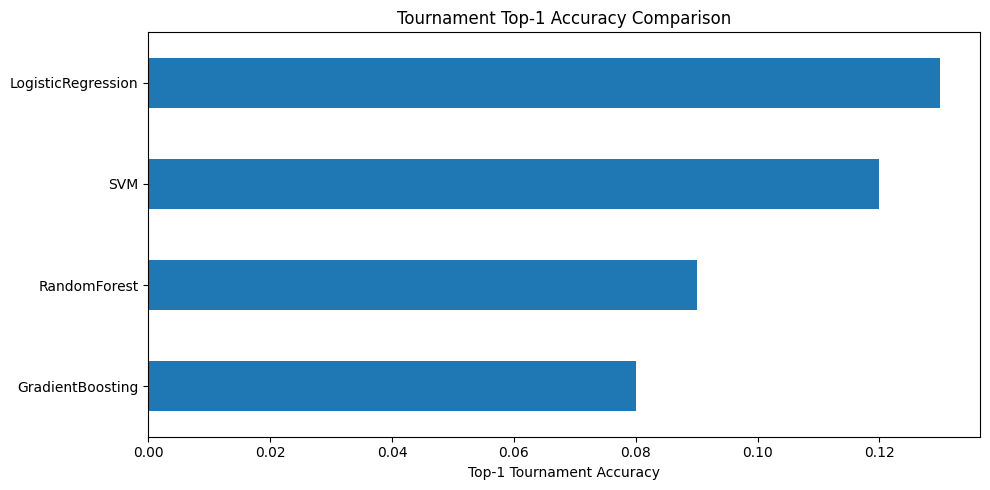

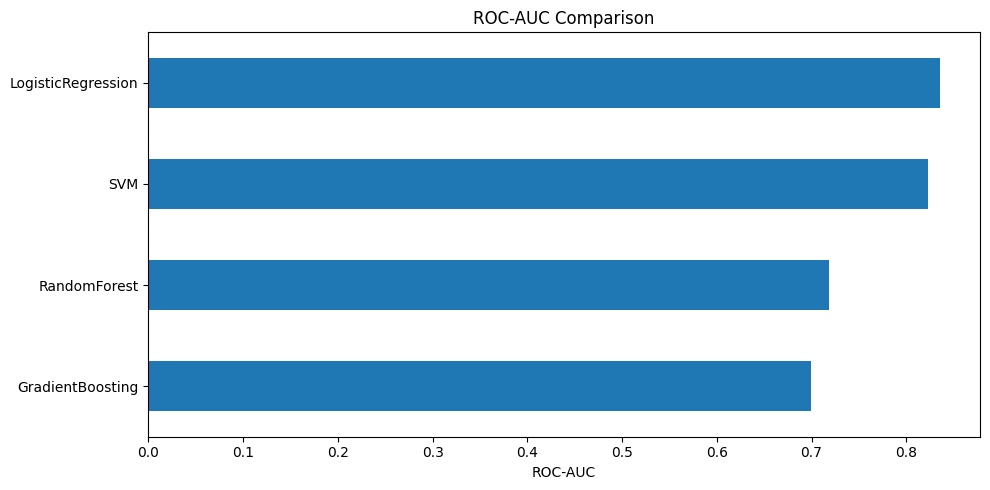

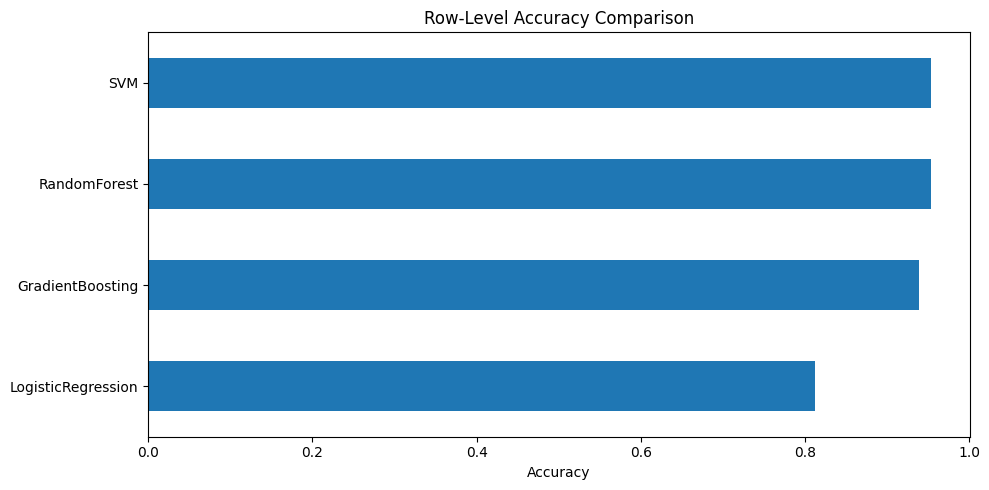

In [17]:
# -------------------------------------------------------------
# MODEL COMPARISON PLOTS (Accuracy, ROC-AUC, Tournament Top-1)
# -------------------------------------------------------------
import matplotlib.pyplot as plt

# Convert results dictionary into a DataFrame
results_df = pd.DataFrame(results).T[
    ['accuracy', 'roc_auc', 'top1_tournament_acc']
]

print("\nModel Comparison Table:\n")
print(results_df)

# ---- PLOT 1: Tournament Top-1 Accuracy ----
plt.figure(figsize=(10,5))
results_df['top1_tournament_acc'].sort_values().plot(
    kind='barh', title='Tournament Top-1 Accuracy Comparison'
)
plt.xlabel("Top-1 Tournament Accuracy")
plt.tight_layout()
plt.show()

# ---- PLOT 2: ROC-AUC ----
plt.figure(figsize=(10,5))
results_df['roc_auc'].sort_values().plot(
    kind='barh', title='ROC-AUC Comparison'
)
plt.xlabel("ROC-AUC")
plt.tight_layout()
plt.show()

# ---- PLOT 3: Row-Level Accuracy ----
plt.figure(figsize=(10,5))
results_df['accuracy'].sort_values().plot(
    kind='barh', title='Row-Level Accuracy Comparison'
)
plt.xlabel("Accuracy")
plt.tight_layout()
plt.show()


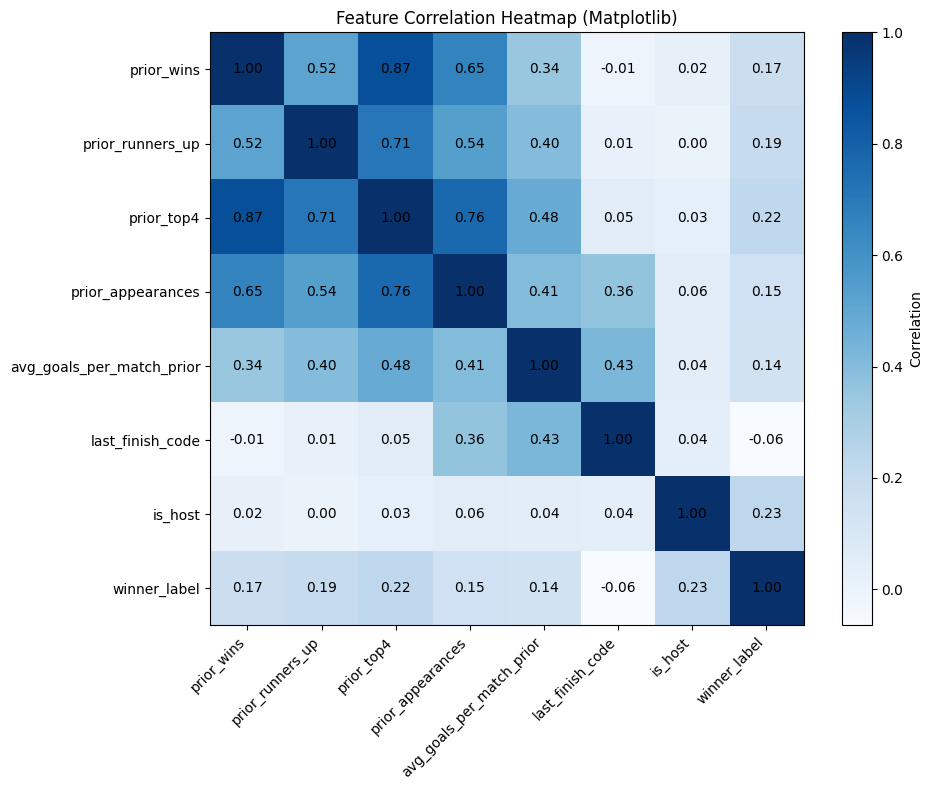

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Select numeric feature columns
corr = features_df[
    ['prior_wins','prior_runners_up','prior_top4',
     'prior_appearances','avg_goals_per_match_prior',
     'last_finish_code','is_host','winner_label']
].corr()

# ---- MATPLOTLIB HEATMAP ----
plt.figure(figsize=(10, 8))

plt.imshow(corr, cmap='Blues', interpolation='nearest')
plt.colorbar(label='Correlation')

# Add ticks
plt.xticks(
    range(len(corr.columns)),
    corr.columns,
    rotation=45,
    ha='right'
)
plt.yticks(range(len(corr.columns)), corr.columns)

# Add correlation numbers on the heatmap
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = f"{corr.iloc[i, j]:.2f}"
        plt.text(j, i, text,
                 ha='center', va='center', color='black')

plt.title("Feature Correlation Heatmap (Matplotlib)")
plt.tight_layout()
plt.show()
